In [1]:
from dottamine import dotim
import numpy as np
import skimage as sk
# import napari
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import center_of_mass, rotate, gaussian_filter, zoom
import matplotlib.pyplot as plt
import copy

In [2]:
mask = sk.io.imread('domes/70_denoised_mask.tif').astype(np.uint8)
image = sk.io.imread('domes/70_denoised.tif')
original_image = copy.copy(image[3])
image = np.transpose(image[3], axes=(1, 0, 2))
image = np.transpose(image, axes=(2, 1, 0))

# 3D workflow

scipy.ndimage.rotate(input, angle, axes=(1, 0), reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)

Rotate an array.

The array is rotated in the plane defined by the two axes given by the axes parameter using spline interpolation of the requested order.

In [6]:
## Close the mask
closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

## Find the top line of the mask
closed_mask = np.array(closed_mask)
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
first_nonzero_indices = first_nonzero_indices

## Move up or down the line
first_nonzero_indices = first_nonzero_indices + 0 # Units to move the line. If > 0  the line will be lower, useful to get the basal? If < 0 the line will be higher.
first_nonzero_indices[first_nonzero_indices < 0] = 0
first_nonzero_indices[first_nonzero_indices >= closed_mask.shape[1]] = closed_mask.shape[1]-1
## Fi move up or down the line

top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask

top_mask[:,0,:] = 0

top_mask = top_mask.astype(np.float64)

filtered = gaussian_filter(top_mask, 30)
epithelial = filtered*image


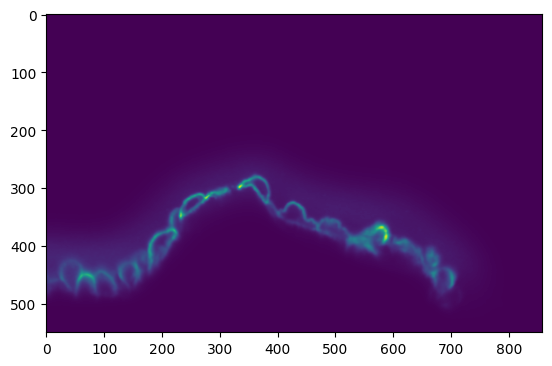

In [8]:
plt.imshow(epithelial[300])

In [10]:
print(epithelial.dtype)

float64


In [13]:
import tifffile as tiff
epithelial2 = epithelial.astype(np.float32)
tiff.imwrite('./../ppujol/dome70_2/maskedImage3D.tif', epithelial2, imagej=True)

: 

# 2D slices

Now we have a 3d stack of the "clean image".

We will try to do it in 2d slices. Try to rotate them the other way around.

In [5]:
def shape_finder_2D(height_mask):

    angles = [i for i in range(-60, 60+1, 10)]

    total_cell_mask = np.zeros(shape=(height_mask.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_height_mask = rotate(height_mask, angle, reshape=False) # Be careful of the reshape=False
        # cell_top_mask_rot = rotate(height_matrix, angle)

        ## Find the border of the cell which is the maximum of this masked image.
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_height_mask.shape[1]):
            col = rot_height_mask[:, i]
            max_pos = np.argmax(col == max(col))
            # max_pos = find_first_local_max(col)
            if max_pos <= len(col)-200:
                cell_border.append(max_pos) # Search for the first max
            else:
                cell_border.append('-')

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_height_mask)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)

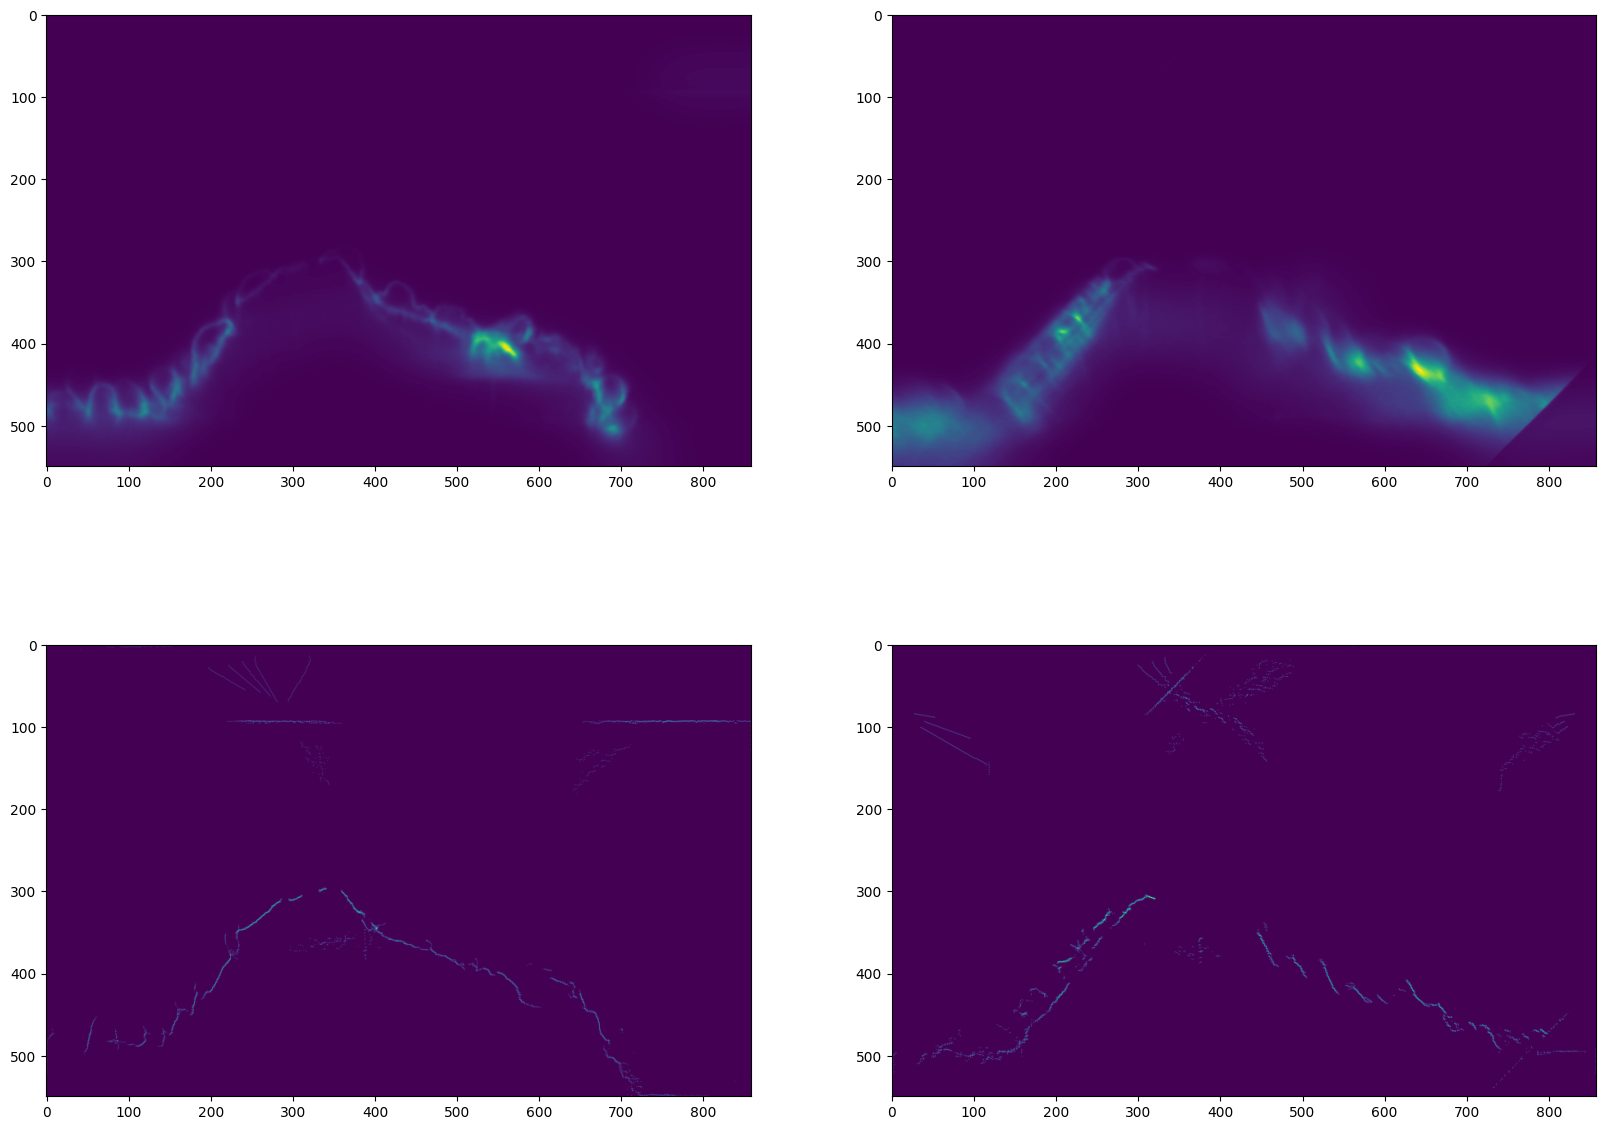

In [6]:
plt.figure(figsize=(20,15))

plt.subplot(221)
plt.imshow(epithelial[300])
plt.subplot(223)
plt.imshow(shape_finder_2D(epithelial[300]))

epithelial_rot = np.transpose(epithelial, axes=(2,1,0))
plt.subplot(222)
plt.imshow(epithelial_rot[300])
plt.subplot(224)
plt.imshow(shape_finder_2D(epithelial_rot[300]))

In [7]:
epithelial_shape = []
for i in range(epithelial.shape[0]):
    epithelial_shape.append(shape_finder_2D(epithelial[i]))
    print(f'{i+1}/{epithelial.shape[0]}', end='\r')
epithelial_shape = np.array(epithelial_shape)

In [8]:
epithelial_rot_shape = []
for i in range(epithelial_rot.shape[0]):
    epithelial_rot_shape.append(shape_finder_2D(epithelial_rot[i]))
    print(f'{i+1}/{epithelial_rot.shape[0]}', end='\r')
epithelial_rot_shape = np.array(epithelial_rot_shape)

: 

In [ ]:
epithelial_rot_shape = np.transpose(epithelial_rot_shape, axes=(2,1,0))

In [ ]:
total_epithelial_shape = epithelial_shape + epithelial_rot_shape

In [ ]:
import tifffile as tiff
total_epithelial_shape = total_epithelial_shape.astype(np.uint16)
tiff.imwrite("./../3Dtotal_epithelial_shape_basal.tif", total_epithelial_shape, imagej=True)

In [4]:
total_epithelial_shape = sk.io.imread('./../ppujol/dome70_2/3Dtotal_epithelial_shape.tif')

# FI 2D

In [4]:
max_values = np.amax(epithelial, axis=1)
z_epithelial = np.transpose(epithelial, axes=(1,0,2))
max_positions = np.where(z_epithelial == max_values)
max_positions = np.array(max_positions)
max_positions = np.transpose(max_positions)
cell_top_mask = np.zeros_like(z_epithelial)
cell_top_mask[max_positions[:, 0], max_positions[:, 1], max_positions[:, 2]] = 1

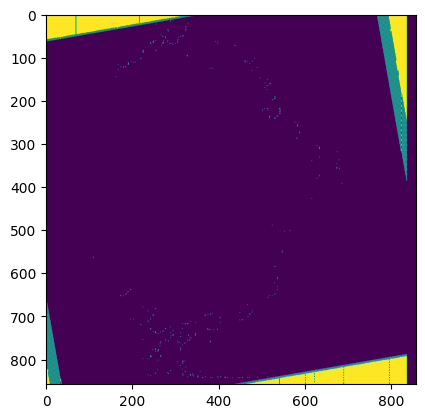

In [29]:
plt.imshow(cell_top_mask[430])

In [5]:
rotated_epithelial = rotate(epithelial, 25, axes=(1,2), reshape=False)

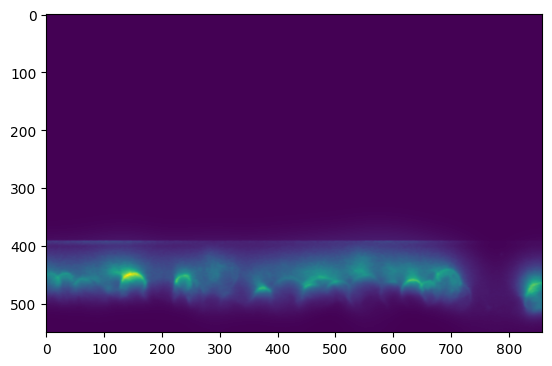

In [15]:
plt.imshow(epithelial[00])

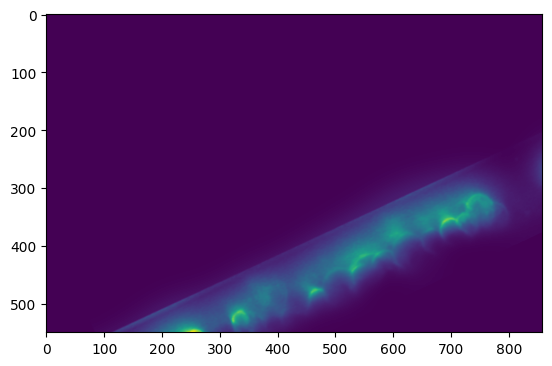

In [14]:
plt.imshow(rotated_epithelial[00])

In [8]:
max_values = np.amax(rotated_epithelial, axis=1)
z_epithelial = np.transpose(rotated_epithelial, axes=(1,0,2))
max_positions = np.where(z_epithelial ==  max_values)
max_positions = np.array(max_positions)
max_positions = np.transpose(max_positions)
cell_top_mask = np.zeros_like(z_epithelial)
cell_top_mask[max_positions[:, 0], max_positions[:, 1], max_positions[:, 2]] = 1

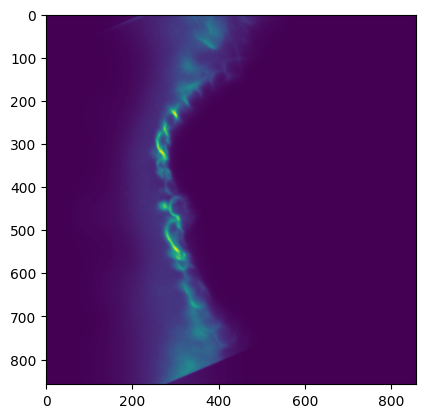

In [16]:
plt.imshow(z_epithelial[500])

In [10]:
cell_top_mask = rotate(cell_top_mask, -25, axes=(0,2), reshape=False)

In [11]:
cell_top_mask = cell_top_mask.astype(np.uint16)

In [12]:
import tifffile as tiff

tiff.imwrite("./../ppujol/dome70/3DMaskOnlyTop_10degree.tif", cell_top_mask, imagej=True)

1.0 0.0


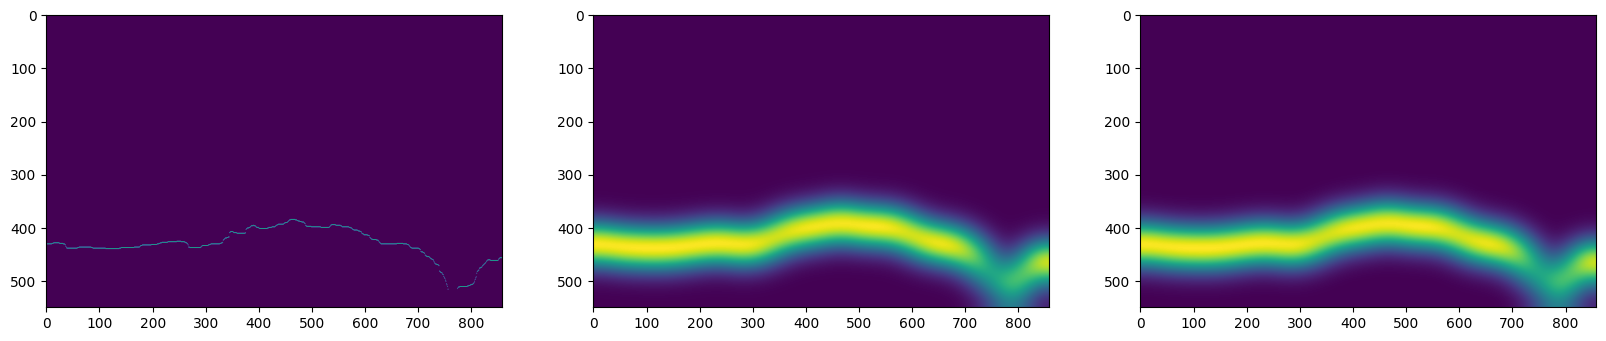

In [115]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(top_mask[100])
plt.subplot(132)
expanded = gaussian_filter(top_mask[100], 30)
print(top_mask.max(), top_mask.min())
plt.imshow(expanded)
plt.subplot(133)
expanded2 = cv2.GaussianBlur(top_mask[100], (199, 199), 0)
plt.imshow(expanded2)

dtype('float64')

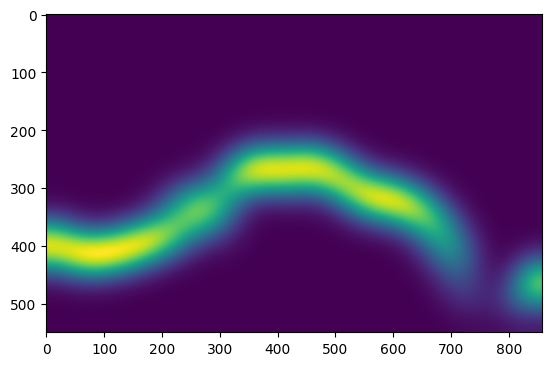

In [120]:
plt.imshow(filtered[430])

In [ ]:
# cell_mask = []

# for i in list(range(top_mask.shape[0])):

#     i = 430

#     print(i, end='\r')

#     slice_y = i

#     ## Find the heights of the top mask array 
#     height = [] # Is an array that contains the y values at which the mask starts
#     for i in range(top_mask[slice_y].shape[1]):
#         col = top_mask[slice_y][:, i]
#         height.append(np.where(col == 1)[0][0]-20) # Add a value to move the line (+20)
#     height = np.array(height)

#     ## Smooth the top line
#     window_size = 20
#     height = smooth_array(height, window_size)

#     ## Put the line inside a matrix. We have smoothed each line since top_mask is already this height matrix but non-smoothed.
#     height_matrix = np.zeros((top_mask[slice_y].shape)) # Is the smoothed line on top of the mask

#     for i in range(height_matrix.shape[1]-1):
#         if abs(height[i]-height[i+1]) < 10: # Check the absolute difference value! # Should also take into account that two separate points toghether will also appear. (STD?)
#             if height[i] == 0 and height[i-1] == 0:
#                 continue
#             height_matrix[int(height[i])][i] = 1

#     plt.imshow(height_matrix)

#     break

    # ## Blur the alone line and multiply it by the original image in order to get a masked image
    # height_mask = cv2.GaussianBlur(height_matrix, (199, 199), 0)*image[slice_y]

    # angles = [i for i in range(-60, 60+1, 5)]

    # total_cell_mask = np.zeros(shape=(height_mask.shape))

    # for angle in angles:

    #     ## Rotate the masked image.        
    #     rot_height_mask = rotate(height_mask, angle, reshape=False) # Be careful of the reshape=False
    #     # cell_top_mask_rot = rotate(height_matrix, angle)

    #     ## Find the border of the cell which is the maximum of this masked image.
    #     cell_border = []

    #     ## Get the position of the maximum intensity.
    #     for i in range(rot_height_mask.shape[1]):
    #         col = rot_height_mask[:, i]
    #         cell_border.append(np.argmax(col == max(col))) # Search for the first max

    #     ## Put the positions in a matrix as we have done with the smoothed line before.
    #     cell_top_mask_rot = np.zeros_like(rot_height_mask)
    #     for i in range(cell_top_mask_rot.shape[1]):
    #         cell_top_mask_rot[cell_border[i], i] = 1

    #     ## Rotate the matrix to have it horizontal as the original image.
    #     cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
    #     cell_top_mask_rot[cell_top_mask_rot < 0] = 0
    #     total_cell_mask += cell_top_mask_rot

    # cell_mask.append(total_cell_mask)

In [8]:
cell_mask = np.array(cell_mask)
cell_mask = cell_mask.astype(np.uint16)

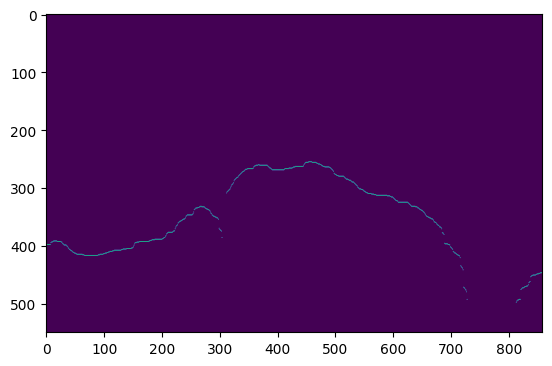

In [8]:
# mask_cell_mask = cell_mask*mask
plt.imshow(top_mask[430])

In [32]:
import tifffile as tiff

tiff.imwrite("./../ppujol/dome70/Image_equal_axis.tif", top_mask, imagej=True)

In [24]:
def fill(mat):
    for j in range(len(mat[0])):
        found_top_one = False
        for i in range(len(mat)):
            if mat[i][j] == 1:
                found_top_one = True
            elif found_top_one:
                mat[i][j] = 1
    return mat


def fill_below_top_ones(matrix):

    matrix = np.array(matrix)
    result_matrix = []
    ndim = len(matrix.shape)
    if ndim == 2:
        result_matrix = fill(matrix)
    if ndim == 3:
        for m in matrix:
            result_matrix.append(fill(m))

    return result_matrix

In [26]:
filled_mask = fill_below_top_ones(top_mask)

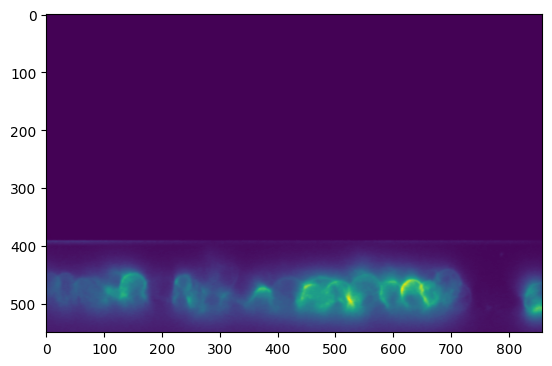

In [31]:
plt.imshow(image[1])